In [1]:
from data_loader import DataGenerator
from datetime import datetime
from model import cnn_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm
np.set_printoptions(suppress=True)
n_batches = 320

In [2]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix].flatten(),
                                     preds[i, m_ix].flatten()))
    overall_err_med = np.median(errs)
    overall_err_mean = np.mean(errs)
    mods_err_med = np.median(err_of_mods)
    mods_err_mean = np.mean(err_of_mods)
    return {"err (med, mean)": (overall_err_med, overall_err_mean), 
            "modifications_err (med, mean)": (mods_err_med, mods_err_mean)}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_roll_mses(mse):
    roll_mses = []
    for idx in rolling_window(np.arange(mse.shape[0]), 4):
        roll_mses.append(np.median(mse))
    return np.array(roll_mses)

def get_y(X, preds, mses, threshold):
    y_true = []
    y_pred = []
    for sample, pred, mse in tqdm(zip(X, preds, mses)):
        if np.where(mse > threshold):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [3]:
data_generator_config['quality_threshold'] = 20.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 64
# data_generator_config['motifs'] = ["CCAGG", "CCTGG", "GATC"]
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 20.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 64,
 'load2ram': False,
 'test': True,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [4]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [5]:
X = []
modifs_idx = []
modifs_type = []
for _ in tqdm(range(n_batches)):
    x, m_idx, type_ = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)
    modifs_type.append(type_)

 13%|█▎        | 43/320 [01:02<04:37,  1.00s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 89%|████████▉ | 285/320 [07:03<00:28,  1.22it/s]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 320/320 [07:50<00:00,  1.47s/it]


In [6]:
X = np.array(X).reshape(n_batches*data_loader.batch_size, 
                        data_loader.sample_len, 1)
shape_ = (n_batches*data_loader.batch_size, data_loader.sample_len)
modifs_idx = np.array(modifs_idx).reshape(shape_[0])
modifs_idx = modifs_idx.flatten()

In [7]:
from tensorflow.keras import layers
clear_session()
model64 = load_model(r"1612/64_CNN.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model64, X, MSE, shape_))
print("MAE: ", get_err_of_model(model64, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.026580337, 0.027800487), 'modifications_err (med, mean)': (0.073230974, 0.089759864)}
MAE:  {'err (med, mean)': (0.11655973, 0.11715461), 'modifications_err (med, mean)': (0.20279285, 0.21518749)}


In [8]:
from tensorflow.keras import layers
clear_session()
model32 = load_model(r"1312/32_CNN.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model32, X, MSE, shape_))
print("MAE: ", get_err_of_model(model32, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.0546649, 0.056675877), 'modifications_err (med, mean)': (0.124938294, 0.15795714)}
MAE:  {'err (med, mean)': (0.17461228, 0.17549528), 'modifications_err (med, mean)': (0.28954846, 0.30992073)}


In [9]:
data_generator_config['quality_threshold'] = 14
data_generator_config['test'] = False

In [10]:
preds32 = model32.predict(X)
preds64 = model64.predict(X)
X_shaped = X.reshape(shape_)
preds_shaped = preds32.reshape(shape_)
preds_shaped = preds64.reshape(shape_)

In [11]:
now = datetime.now()
model32.predict(X[:1000])
print("pred speed 32: ", datetime.now() - now)
now = datetime.now()
model64.predict(X[:1000])
print("pred speed 64: ", datetime.now() - now)

pred speed 32:  0:00:00.782053
pred speed 64:  0:00:00.613473


In [12]:
with_modif = np.array([i for i, ix in enumerate(modifs_idx) if 3 < len(ix) < 50])
without_modif = np.array([i for i, ix in enumerate(modifs_idx) if not len(ix)])
print(with_modif.shape)
print(without_modif.shape)

(81792,)
(235494,)


In [13]:
without_modif = without_modif[::2]

In [14]:
X_cropped = X[:, 100:-100]
preds_cropped32 = preds32[:, 100:-100]
preds_cropped64 = preds64[:, 100:-100]

In [15]:
modif_ix = []
with_modif_in_middle = []
for ix in with_modif:
    if modifs_idx[ix][0] > 200 and modifs_idx[ix][-1] < 312:
        modif_ix.append(modifs_idx[ix] - 100)
        with_modif_in_middle.append(ix)
with_modif_in_middle = np.array(with_modif_in_middle)

In [19]:
X_cropped = X_cropped.reshape(X_cropped.shape[0],
                              X_cropped.shape[1])
preds_cropped32 = preds_cropped32.reshape(preds_cropped32.shape[0],
                                          preds_cropped32.shape[1])
preds_cropped64 = preds_cropped64.reshape(preds_cropped64.shape[0],
                                          preds_cropped64.shape[1])

mses32 = (X_cropped - preds_cropped32)**2
mses64 = (X_cropped - preds_cropped64)**2

In [20]:
mae32 = MAE(X_cropped, preds_cropped32)
mae64 = MAE(X_cropped, preds_cropped64)

In [24]:
print(np.mean(mses32[without_modif]))
print(np.mean(mses64[without_modif]))
print(np.mean(mses32[with_modif]))
print(np.mean(mses64[with_modif]))
print(np.mean(mae32))
print(np.mean(mae64))

0.054478347225476696
0.02574682294257412
0.05926366197953742
0.02779846832896382
0.17430347
0.1143034


In [22]:
without_modif_set = set(without_modif)
with_modif_in_middle_set = set(with_modif_in_middle)
if len(without_modif_set.intersection(set(with_modif_in_middle))):
    raise ValueError("hmm")

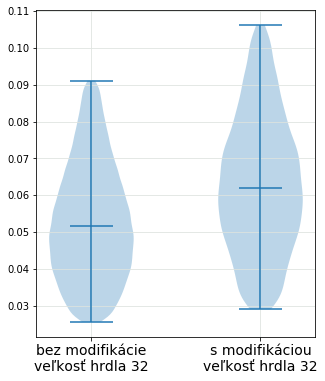

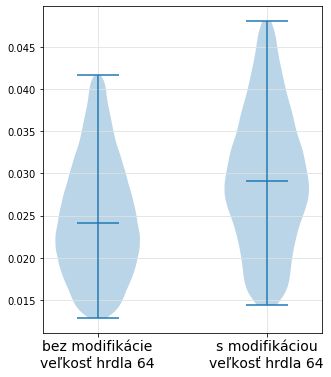

In [23]:
avg_mse_with32 = mses32[with_modif_in_middle].mean(1)
avg_mse_with64 = mses64[with_modif_in_middle].mean(1)
avg_mse_without32 = mses32[without_modif].mean(1)
avg_mse_without64 = mses64[without_modif].mean(1)

p_min_without64 = np.percentile(avg_mse_without64, 5)
p_max_without64 = np.percentile(avg_mse_without64, 95)
p_min_with64 = np.percentile(avg_mse_with64, 5)
p_max_with64 = np.percentile(avg_mse_with64, 95)
without64_avg = avg_mse_without64[(avg_mse_without64 > p_min_without64) 
                              & (avg_mse_without64 < p_max_without64)]
with64_avg = avg_mse_with64[(avg_mse_with64 > p_min_with64) 
                        & (avg_mse_with64 < p_max_with64)]


p_min_without32 = np.percentile(avg_mse_without32, 5)
p_max_without32 = np.percentile(avg_mse_without32, 95)
p_min_with32 = np.percentile(avg_mse_with32, 5)
p_max_with32 = np.percentile(avg_mse_with32, 95)
without32_avg = avg_mse_without32[(avg_mse_without32 > p_min_without32) 
                             & (avg_mse_without32 < p_max_without32)]
with32_avg = avg_mse_with32[(avg_mse_with32 > p_min_with32) 
                        & (avg_mse_with32 < p_max_with32)]

plt.figure(figsize=(5, 6))
plt.violinplot([without32_avg, with32_avg], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 32', 
                     's modifikáciou\nveľkosť hrdla 32'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_1.png')
plt.show()
plt.figure(figsize=(5, 6))
plt.violinplot([without64_avg, with64_avg], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 64', 
                     's modifikáciou\nveľkosť hrdla 64'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_2.png')
plt.show()



In [26]:
np.median(mses64[without_modif].mean(1)) / np.median(mses64[with_modif_in_middle].mean(1))

0.8306415792473171

In [27]:
median_rolled_mses_without32 = []
median_rolled_mses_with32 = []
median_rolled_mses_without64 = []
median_rolled_mses_with64 = []

for idx in tqdm(range(len(mses32))):
    if idx not in without_modif_set and idx not in with_modif_in_middle_set:
        continue
    if idx in without_modif_set:
        median_rolled_mses_without32.append(get_roll_mses(mses32[idx]))
        median_rolled_mses_without64.append(get_roll_mses(mses64[idx]))

    if idx in with_modif_in_middle_set:
        median_rolled_mses_with32.append(get_roll_mses(mses32[idx]))
        median_rolled_mses_with64.append(get_roll_mses(mses64[idx]))

avg_mse_with32 = mses32[with_modif_in_middle].mean(1)
avg_mse_with64 = mses64[with_modif_in_middle].mean(1)
avg_mse_without32 = mses32[without_modif].mean(1)
avg_mse_without64 = mses64[without_modif].mean(1)

median_rolled_mses_without32 = np.array(median_rolled_mses_without32)
median_rolled_mses_with32 = np.array(median_rolled_mses_with32)
avg_mse_without32 = np.array(avg_mse_without32)
avg_mse_with32 = np.array(avg_mse_with32)

median_rolled_mses_without64 = np.array(median_rolled_mses_without64)
median_rolled_mses_with64 = np.array(median_rolled_mses_with64)
avg_mse_without64 = np.array(avg_mse_without64)
avg_mse_with64 = np.array(avg_mse_with64)

with open("evaluation.npz", "wb") as f:
    np.savez(f, mses32, mses64, median_rolled_mses_without32, median_rolled_mses_with32, 
             avg_mse_without32, avg_mse_with32, median_rolled_mses_without64, 
             median_rolled_mses_with64)

  9%|▉         | 28020/320000 [13:07<2:16:49, 35.56it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-dc6f9821a1df>", line 10, in <module>
    median_rolled_mses_without32.append(get_roll_mses(mses32[idx]))
  File "<ipython-input-2-118840f34eb3>", line 24, in get_roll_mses
    roll_mses.append(np.median(mse))
  File "<__array_function__ internals>", line 6, in median
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py", line 3495, in median
    overwrite_input=overwrite_input)
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py", line 3403, in _ureduce
    r = func(a, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py", line 3528, in _median
    part = partition(a, kth, axis=axis)
  File "<__array_function__ internals>", line 6, in partition
  File "/usr/local/lib/python3.6/dist-packages/numpy/

KeyboardInterrupt: 

In [ ]:
max_mse_with32 = median_rolled_mses_with32.max(1)
max_mse_with64 = median_rolled_mses_with64.max(1)
max_mse_without32 = median_rolled_mses_without32.max(1)
max_mse_without64 = median_rolled_mses_without64.max(1)
max_mse_without64 *= 2.5
max_mse_with64 *= 2.5
p_min_without64 = np.percentile(max_mse_without64, 5)
p_max_without64 = np.percentile(max_mse_without64, 95)
p_min_with64 = np.percentile(max_mse_with64, 5)
p_max_with64 = np.percentile(max_mse_with64, 95)
without64_max = max_mse_without64[(max_mse_without64 > p_min_without64) 
                              & (max_mse_without64 < p_max_without64)]
with64_max = max_mse_with64[(max_mse_with64 > p_min_with64) 
                        & (max_mse_with64 < p_max_with64)]


p_min_without32 = np.percentile(max_mse_without32, 5)
p_max_without32 = np.percentile(max_mse_without32, 95)
p_min_with32 = np.percentile(max_mse_with32, 5)
p_max_with32 = np.percentile(max_mse_with32, 95)
without32_max = max_mse_without32[(max_mse_without32 > p_min_without32) 
                             & (max_mse_without32 < p_max_without32)]
with32_max = max_mse_with32[(max_mse_with32 > p_min_with32) 
                        & (max_mse_with32 < p_max_with32)]

plt.figure(figsize=(5, 6))
plt.violinplot([without32_max, with32_max], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 32', 
                     's modifikáciou\nveľkosť hrdla 32'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_max_1.png')
plt.show()
plt.figure(figsize=(5, 6))
plt.violinplot([without64_max, with64_max], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 64', 
                     's modifikáciou\nveľkosť hrdla 64'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_max_2.png')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
from matplotlib import pyplot as plt

In [ ]:
precisions = []
recalls = []
accuracies = []
avg_mse_with64 = mses64[with_modif_in_middle].mean(1) * 2
avg_mse_without64 = mses64[without_modif].mean(1) * 2
avg_mse64 = mses64.mean(1)
for thr in tqdm(np.linspace(np.min(avg_mse_with64), avg_mse_with64.max(), 300)):
    y_true = []
    y_pred = []
    for idx, mse in enumerate(avg_mse64):
        if idx not in without_modif_set and idx not in with_modif_in_middle_set:
            continue
        mse *= 2
        y_pred.extend([1 if mse > thr else 0 for i in [1]])
        y_true.extend([1 if idx in with_modif_in_middle_set else 0 for _ in [1]])
        
    w = precision_score(y_true, y_pred)
    precisions.append(w)
    recalls.append(recall_score(y_true, y_pred))
    accuracies.append(accuracy_score(y_true, y_pred))
print(recalls)

In [ ]:
np.max(accuracies) + len(with_modif_in_middle_set) / len(without_modif_set)

In [ ]:
np.max(precisions)

In [ ]:
# preds = model1.predict(X)
x = np.arange(X[29].flatten().shape[0])
plt.plot(x, X[29].flatten(), label="vstup")
plt.plot(x, preds64[29].flatten(), label="výstup")
plt.legend()
plt.show()

In [ ]:
from fast5_research import Fast5
import numpy as np
from glob import glob
from config import test_seq_path, seq_path, corrected_group
files_list = glob(test_seq_path) + glob(seq_path)

In [ ]:
leng = 0
num = 0
leng_events = 0
num_events = 0
is_not_okay = 0
for filename in tqdm(files_list):
    try:
        with Fast5(filename) as fh:
            leng += len(fh.get_read(raw=True))
            t_path = f'Analyses/{corrected_group}/BaseCalled_template/Events/'
            c_path = f'Analyses/{corrected_group}/BaseCalled_complement/Events/'
            try:
                l_ = fh[c_path]['start'][-1] + fh[c_path]['length'][-1]
                l_ += (fh[t_path]['start'][-1] + fh[t_path]['length'][-1])
                num_events += len(fh[c_path]['start']) + len(fh[t_path]['start'])
                leng_events += l_
            except:
                is_not_okay += 1
            num += 1
    except OSError:
        print(filename)


In [ ]:
is_not_okay

In [ ]:
avg_read_len = leng/num

In [ ]:
num_events

In [ ]:
avg_num_events_in_read = num_events/(num-is_not_okay)
avg_num_events_in_read

In [ ]:
avg_signal_per_event = leng_events / num_events
avg_signal_per_event